In [43]:
import pandas as pd
import numpy as np

In [44]:
columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
           "wrong_fragment","urgent","hot","num_failed_logins","logged_in",
           "num_compromised","root_shell","su_attempted","num_root","num_file_creations",
           "num_shells","num_access_files","num_outbound_cmds","is_host_login",
           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
           "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate",
           "srv_diff_host_rate","dst_host_count","dst_host_srv_count",
           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
           "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty"]

In [45]:
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"

In [46]:
try:
    df = pd.read_csv(url, names=columns)
    print(f"Successfully loaded {len(df)} rows!")
    print(df.head())
except Exception as e:
    print(f"Error loading data: {e}")

Successfully loaded 125973 rows!
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60              

In [47]:
df['target']=df['label'].apply(lambda x: 0 if x =='normal' else 1)

In [48]:
df.drop(['label','difficulty'], axis=1, inplace=True)

In [49]:
print(f"Dataset loaded: {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded: 125973 rows and 42 columns.


In [50]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [51]:
from sklearn.preprocessing import LabelEncoder
cat_cols=['protocol_type','service','flag']
le=LabelEncoder()
for col in cat_cols:
  df[col]=le.fit_transform(df[col])
print("Categorical columns encoded successfully")

Categorical columns encoded successfully


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

normal_data = df[df['target'] == 0]
anomaly_data = df[df['target'] == 1]

train_df, test_normal_df = train_test_split(normal_data, test_size=0.2, random_state=42)
test_df=pd.concat([test_normal_df,anomaly_data])

X_train=train_df.drop('target',axis=1)
X_test=test_df.drop('target',axis=1)
y_test=test_df['target']

scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

print(f"Ready! Training on {X_train_scaled.shape[0]} normal samples.")
print(f"Testing on {X_test_scaled.shape[0]} mixed samples")

Ready! Training on 53874 normal samples.
Testing on 72099 mixed samples


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense

In [54]:
input_dim=X_train_scaled.shape[1]

Initial Model

In [55]:
input_layer_v1=Input(shape=(input_dim,))
x1=Dense(32,activation='relu')(input_layer_v1)
x1=Dense(16,activation='relu')(x1)
bottleneck_v1=Dense(8,activation='relu')(x1)

In [56]:
x1=Dense(16,activation='relu')(bottleneck_v1)
x1=Dense(32,activation='relu')(x1)
decoder=Dense(64,activation='relu')(x1)
output_layer_v1=Dense(input_dim,activation='sigmoid')(x1)

In [57]:
autoencoder_v1=Model(inputs=input_layer_v1,outputs=output_layer_v1)
autoencoder_v1.compile(optimizer='adam',loss='mse')

In [58]:
print("Training Baseline Model...")
autoencoder_v1.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=64, validation_split=0.1, verbose=0)

Training Baseline Model...


In [59]:
train_mse_v1 = np.mean(np.power(X_train_scaled - autoencoder_v1.predict(X_train_scaled), 2), axis=1)
threshold_v1 = np.mean(train_mse_v1) + 3 * np.std(train_mse_v1)

1684/1684 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [60]:
mse_v1 = np.mean(np.power(X_test_scaled - autoencoder_v1.predict(X_test_scaled), 2), axis=1)
preds_v1 = (mse_v1 > threshold_v1).astype(int)

2254/2254 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [61]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print("\n--- BASELINE RESULTS (v1) ---")
print(classification_report(y_test, preds_v1, target_names=['Normal', 'DDoS']))


--- BASELINE RESULTS (v1) ---
              precision    recall  f1-score   support

      Normal       0.58      0.97      0.72     13469
        DDoS       0.99      0.84      0.91     58630

    accuracy                           0.86     72099
   macro avg       0.78      0.91      0.82     72099
weighted avg       0.92      0.86      0.87     72099



Optimized Model

In [62]:
input_layer_v2 = Input(shape=(input_dim,))
x2 = Dense(64, activation='relu')(input_layer_v2)
x2 = Dense(32, activation='relu')(x2)
x2 = Dense(16, activation='relu')(x2)
bottleneck_v2 = Dense(8, activation='relu')(x2)

In [63]:
x2 = Dense(16, activation='relu')(bottleneck_v2)
x2 = Dense(32, activation='relu')(x2)
x2 = Dense(64, activation='relu')(x2)
output_layer_v2 = Dense(input_dim, activation='sigmoid')(x2)

In [64]:
autoencoder_v2 = Model(inputs=input_layer_v2, outputs=output_layer_v2)
autoencoder_v2.compile(optimizer='adam', loss='mse')

In [65]:
print("Training Optimized Model...")
autoencoder_v2.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=64, validation_split=0.1, verbose=0)

Training Optimized Model...


In [66]:
train_mse_v2 = np.mean(np.power(X_train_scaled - autoencoder_v2.predict(X_train_scaled), 2), axis=1)
threshold_v2 = np.mean(train_mse_v2) + 4 * np.std(train_mse_v2)

1684/1684 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [67]:
mse_v2 = np.mean(np.power(X_test_scaled - autoencoder_v2.predict(X_test_scaled), 2), axis=1)
preds_v2 = (mse_v2 > threshold_v2).astype(int)

2254/2254 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [68]:
print("\n--- OPTIMIZED RESULTS (v2) ---")
print(classification_report(y_test, preds_v2, target_names=['Normal', 'DDoS']))


--- OPTIMIZED RESULTS (v2) ---
              precision    recall  f1-score   support

      Normal       0.69      0.99      0.81     13469
        DDoS       1.00      0.90      0.94     58630

    accuracy                           0.91     72099
   macro avg       0.84      0.94      0.88     72099
weighted avg       0.94      0.91      0.92     72099



In [69]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

t-SNE

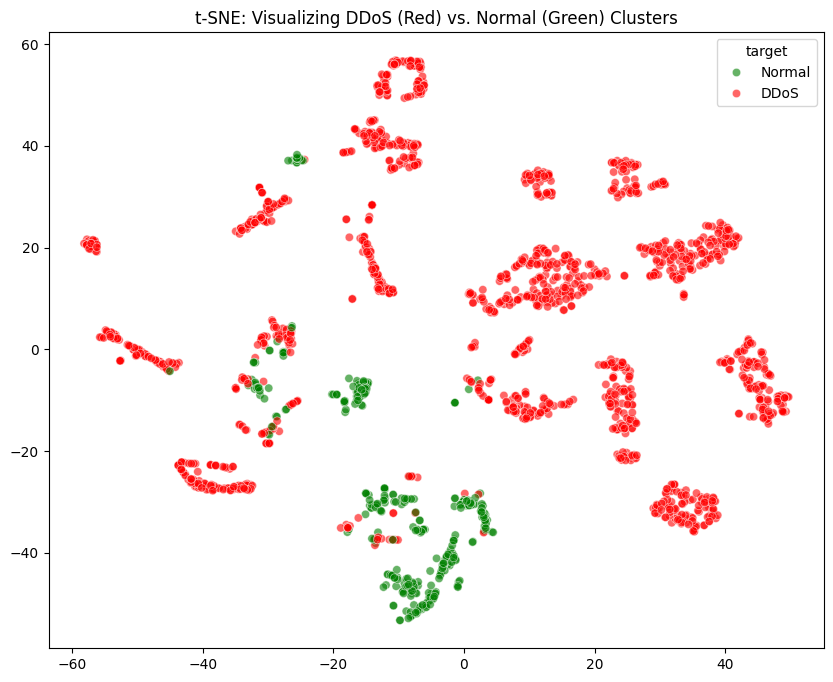

In [70]:
test_df_shuffled = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_sample_raw = test_df_shuffled.drop('target', axis=1)[:2000]
y_sample = test_df_shuffled['target'][:2000]

X_sample_scaled = scaler.transform(X_sample_raw)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=y_sample.replace({0: 'Normal', 1: 'DDoS'}),
    palette={'Normal': 'green', 'DDoS': 'red'},
    alpha=0.6
)
plt.title("t-SNE: Visualizing DDoS (Red) vs. Normal (Green) Clusters")
plt.show()

Isolation Forest

In [71]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [72]:
iso_forest=IsolationForest(n_estimators=100,contamination=0.1,random_state=42)
print("Training isolation Forest..")
iso_forest.fit(X_train_scaled)

Training isolation Forest..


IsolationForest(contamination=0.1, random_state=42)

In [73]:
iso_preds_raw=iso_forest.predict(X_test_scaled)
iso_preds=[1 if x== -1 else 0 for x in iso_preds_raw]
print("/n--- Isolation Forest Results ---")
print(classification_report(y_test,iso_preds,target_names=['Normal','DDoS']))

/n--- Isolation Forest Results ---
              precision    recall  f1-score   support

      Normal       0.75      0.90      0.82     13469
        DDoS       0.98      0.93      0.95     58630

    accuracy                           0.93     72099
   macro avg       0.86      0.92      0.89     72099
weighted avg       0.93      0.93      0.93     72099



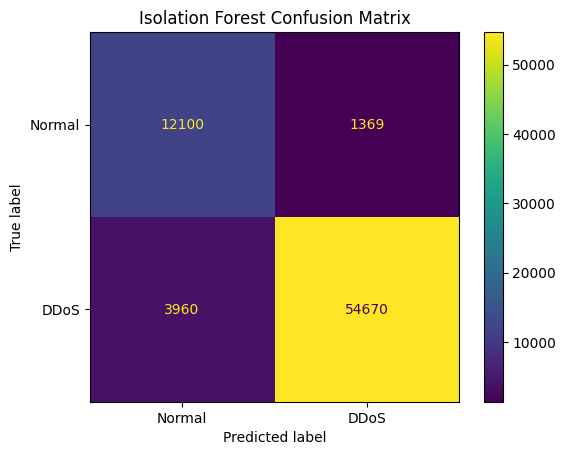

In [74]:
ConfusionMatrixDisplay.from_predictions(y_test,iso_preds,display_labels=['Normal','DDoS'])
plt.title("Isolation Forest Confusion Matrix")
plt.show()

Local Outlier Factor

In [75]:
from sklearn.neighbors import LocalOutlierFactor
lof=LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
print("Training Local Outlier Factor...")
lof.fit(X_train_scaled)

Training Local Outlier Factor...


LocalOutlierFactor(contamination=0.1, novelty=True)

In [76]:
lof_preds_raw=lof.predict(X_test_scaled)
lof_preds=[1 if x== -1 else 0 for x in lof_preds_raw]
print("/n--- Local Outlier Factor Results ---")
print(classification_report(y_test,lof_preds,target_names=['Normal','DDoS']))

/n--- Local Outlier Factor Results ---
              precision    recall  f1-score   support

      Normal       0.37      0.90      0.52     13469
        DDoS       0.97      0.64      0.77     58630

    accuracy                           0.69     72099
   macro avg       0.67      0.77      0.65     72099
weighted avg       0.85      0.69      0.73     72099



VAE

In [144]:
from tensorflow.keras import layers
class Sampling(layers.Layer):
  def call(self,inputs):
    z_mean, z_log_var=inputs
    batch=tf.shape(z_mean)[0]
    dim=tf.shape(z_mean)[1]
    epsilon=tf.keras.backend.random_normal(shape=(batch,dim))
    return z_mean+tf.exp(0.5*z_log_var)*epsilon
class VAE(Model):
  def __init__(self,encoder,decoder,**kwargs):
    super(VAE,self).__init__(**kwargs)
    self.encoder=encoder
    self.decoder=decoder
    self.total_loss_tracker=tf.keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker=tf.keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker=tf.keras.metrics.Mean(name="kl_loss")
  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]
  def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mse(data, reconstruction), axis=-1)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
            total_loss = reconstruction_loss + (0.001 * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [145]:
print(f"X_train_scaled range: {X_train_scaled.min()} to {X_train_scaled.max()}")
# If this is NOT 0 to 1, the sigmoid activation in the decoder will fail!

X_train_scaled range: 0.0 to 1.0


In [146]:
latent_dim=2
vae_encoder_inputs=layers.Input(shape=(input_dim,))
x=layers.Dense(128,activation='relu')(vae_encoder_inputs)
x=layers.Dense(64,activation='relu')(x)
z_mean=layers.Dense(latent_dim,name="z_mean")(x)
z_log_var=layers.Dense(latent_dim,name="z_log_var")(x)
z=Sampling()([z_mean,z_log_var])
encoder_model=Model(vae_encoder_inputs,[z_mean,z_log_var,z],name="encoder")

In [147]:
latent_inputs=layers.Input(shape=(latent_dim,))
x=layers.Dense(64,activation='relu')(latent_inputs)
x=layers.Dense(128,activation='relu')(x)
vae_outputs=layers.Dense(input_dim,activation='sigmoid')(x)
decoder_model=Model(latent_inputs,vae_outputs,name="decoder")

In [148]:
vae=VAE(encoder_model,decoder_model)
vae.compile(optimizer='adam')

In [149]:
print("Training Variational Autoencoder (VAE)...")
vae.fit(X_train_scaled, epochs=50, batch_size=64, verbose=0)
_, _, z = vae.encoder.predict(X_train_scaled)
train_reconstructions = vae.decoder.predict(z)
train_mse_vae = np.mean(np.square(X_train_scaled - train_reconstructions), axis=1)
threshold_vae = np.mean(train_mse_vae) + 3 * np.std(train_mse_vae)
_, _, z_test = vae.encoder.predict(X_test_scaled)
test_reconstructions = vae.decoder.predict(z_test)
mse_vae = np.mean(np.square(X_test_scaled - test_reconstructions), axis=1)
preds_vae = (mse_vae > threshold_vae).astype(int)
from sklearn.metrics import classification_report
print("\n--- VAE RESULTS (v3) ---")
print(classification_report(y_test, preds_vae, target_names=['Normal', 'DDoS']))

Training Variational Autoencoder (VAE)...
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2254/2254 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

--- VAE RESULTS (v3) ---
              precision    recall  f1-score   support

      Normal       0.75      0.97      0.85     13469
        DDoS       0.99      0.93      0.96     58630

    accuracy                           0.93     72099
   macro avg       0.87      0.95      0.90     72099
weighted avg       0.95      0.93      0.94     72099



94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


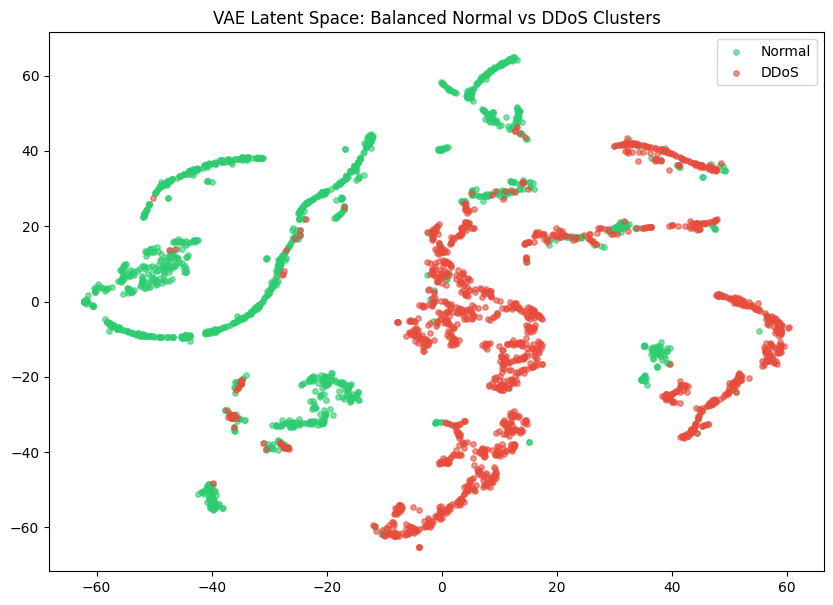

In [150]:
normal_idx = y_test[y_test == 0].index[:1500]
ddos_idx = y_test[y_test == 1].index[:1500]
combined_idx = normal_idx.append(ddos_idx)
X_sample = X_test_scaled[test_df.index.isin(combined_idx)][:3000]
y_sample = y_test[test_df.index.isin(combined_idx)][:3000].values
z_mean_sample, _, _ = vae.encoder.predict(X_sample)
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_mean_sample)
plt.figure(figsize=(10, 7))
for label, color, name in zip([0, 1], ['#2ecc71', '#e74c3c'], ['Normal', 'DDoS']):
    idx = np.where(y_sample == label)
    plt.scatter(z_tsne[idx, 0], z_tsne[idx, 1], c=color, label=name, alpha=0.6, s=15)

plt.title("VAE Latent Space: Balanced Normal vs DDoS Clusters")
plt.legend()
plt.show()